# Jupyter Notebook for Illumination Flat Field

Required packages are: 
`numpy, astropy, photutils, jwst (pipeline), asdf, scipy`

Authors: Tony Sohn, Jo Taylor

# Imports 

In [91]:
# Import all needed packages
import os
import glob
import sys
import collections
import copy
import time
import numpy as np

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Image3Pipeline
import asdf

import astropy
from astropy import units as u
from astropy.nddata import Cutout2D, NDData
from astropy.stats import gaussian_sigma_to_fwhm, sigma_clipped_stats
from astropy.table import Table, hstack
from astropy.modeling import models, fitting
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.wcs import WCS
from astropy.io import ascii

from scipy.stats import norm
import scipy.optimize as opt
from sklearn.metrics import mean_squared_error
from astropy.stats import sigma_clip

import photutils
from photutils import EPSFBuilder, find_peaks
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, RectangularAperture, RectangularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground, SExtractorBackground, ModeEstimatorBackground, MedianBackground
from photutils.background import MADStdBackgroundRMS
from photutils.centroids import centroid_2dg
from photutils.utils import calc_total_error

%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,
        'axes.linewidth':2,'animation.html': 'html5',
        'figure.figsize':(15,15)}
plt.rcParams.update(params)

import jwst
from jwst import datamodels

In [2]:
# Print package versions
print(f'jwst: {jwst.__version__}')
print(f'astropy: {astropy.__version__}')
print(f'numpy: {np.__version__}')
print(f'photutils: {photutils.__version__}')

jwst: 1.1.0
astropy: 4.2.1
numpy: 1.20.1
photutils: 1.1.0


# Read input files and calibrate if needed

<div class="alert alert-block alert-warning">
<u><b>USER INPUT</b></u>
    
You need to define the following variables:
* `start_uncal`: True if starting from uncal files, False if starting from cal files.
* `data_dir`: Directory that holds either uncal or cal files.
* `outdir`: Directory to write output files to.
* `ref_ims`: If you know the reference image for each filter, fill in the dictionary as shown below. If not, leave as an empty dictionary and the first file of each filter will be the reference.
</div>

In [3]:
start_uncal = False # should be either True or False

data_dir = "/ifs/jwst/wit/niriss/tsohn/mirage_simulations/NIS-011/"
outdir = os.path.join(os.getcwd(), "out")
if not os.path.isdir(outdir):
    os.mkdir(outdir)
    
ref_ims = {} # {"F090W": "/ifs/jwst/wit/niriss/tsohn/mirage_simulations/NIS-011/ref_file_cal.fits"}

### Starting from uncal (can still be run if starting from cal)

In [4]:
if start_uncal is True:
    # Get all uncal files
    # If testing just use two uncal files
    #uncals = glob.glob(os.path.join(data_dir, "*_uncal.fits"))
    uncals = [os.path.join(data_dir, x) for x in ["jw01086001001_01101_00021_nis_uncal.fits", "jw01086001001_01101_00045_nis_uncal.fits"]]

    # Modify Image2 parameter ref file to skip photom and resample
    step = Image2Pipeline()
    step.export_config('calwebb_image2.asdf')
    af = asdf.open("calwebb_image2.asdf")
    for i,dct in enumerate(af.tree["steps"]):
        if dct["name"] in ["photom", "resample"]:
            af.tree["steps"][i]["parameters"]["skip"] = True
    new_config = os.path.join(outdir, "calwebb_image3.asdf")
    af.write_to(new_config)

    # Put all files in data dictionary
    data_d = collections.defaultdict(dict)
    for item in uncals:
        det1_out = Detector1Pipeline.call(item, save_results=True, output_dir=outdir)
        im2_out = Image2Pipeline.call(image1_file, save_results=True, config_file=new_config, output_dir=outdir)
        im2_file = os.path.join(outdir, image2[0].meta.filename)
        filt = fits.getval(item, "filter")
        pupil = fits.getval(item, "pupil")
        if filt in ["CLEAR", "CLEARP"]:
            filt = pupil
        photmjsr = im2_out.meta.photometry.conversion_megajanskys
        #print(f"\tConversion factor for DN/s to MJy/Sr: {photmjsr}")
        data_cps = im2_out.data/photmjsr
        if filt not in ref_ims:
            ref_ims[filt] = im2_file
        data_d[filt][im2_file] = {"calfile": im2_file, "cal_datamodel": im2_out, "data_cps": data_cps}

### Starting from cal files (can still be run if starting from uncal)

In [5]:
if start_uncal is False:
    # Get all cal files
    # If testing just use two cal files
    #cals = glob.glob(os.path.join(data_dir, "*_cal.fits"))
    cals = [os.path.join(data_dir, x) for x in ["jw01086001001_01101_00021_nis_cal.fits", "jw01086001001_01101_00045_nis_cal.fits"]]

    # Put all files in data dictionary
    data_d = collections.defaultdict(dict)
    for im2_file in cals:
        filt = fits.getval(im2_file, "filter")
        pupil = fits.getval(im2_file, "pupil")
        if filt in ["CLEAR", "CLEARP"]:
            filt = pupil        
        im2_out = datamodels.open(im2_file)
        photmjsr = im2_out.meta.photometry.conversion_megajanskys
        #print(f"\tConversion factor for DN/s to MJy/Sr: {photmjsr}")
        data_cps = im2_out.data/photmjsr
        if filt not in ref_ims:
            ref_ims[filt] = im2_file
        data_d[filt][im2_file] = {"calfile": im2_file, "cal_datamodel": im2_out, "data_cps": data_cps}

In [6]:
# Display the reference image for each filter
for filt,filt_d in data_d.items():
    fname = ref_ims[filt]
    file_d = filt_d[fname]
    data_cps = file_d["data_cps"]
    normlzd = simple_norm(data_cps, 'sqrt', percent=99.)
    plt.xlabel("X [pix]")
    plt.ylabel("Y [pix]")
    plt.imshow(data_cps, norm=normlzd, cmap="Greys", origin='lower')
    plt.title(f"{filt.upper()}, {os.path.basename(fname)}")

# Identify Sources

In [7]:
# Estimate background and identify stars to be used for building PSF via photutils tasks 
# The parameters below work generally well for NIRISS images

bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()

# Define parameters for each image, in case we want to tweak params for certain exposures
# Right now, just use same params for all images
for filt,filt_d in data_d.items():
    print(filt)
    for fname,file_d in filt_d.items():
        data_cps = file_d["data_cps"]
        std = bkgrms(data_cps)
        bkg = mmm_bkg(data_cps)
        starfinder = IRAFStarFinder(threshold=100*std + bkg, fwhm=2.0, minsep_fwhm=7, 
                                    roundlo=0.0, roundhi=0.6, sharplo=0.6, sharphi=1.4)
        sources = starfinder(data_cps)
        file_d["sources"] = sources
        print(fname)
        print(f"\tBackground: {bkg}, StdDev: {std}, Sources: {len(sources)}")

F150W
/ifs/jwst/wit/niriss/tsohn/mirage_simulations/NIS-011/jw01086001001_01101_00021_nis_cal.fits
	Background: 0.9796515693911809, StdDev: 0.4934196078045637, Sources: 4446
/ifs/jwst/wit/niriss/tsohn/mirage_simulations/NIS-011/jw01086001001_01101_00045_nis_cal.fits
	Background: 0.9854911925264886, StdDev: 0.48971566852247755, Sources: 4485


In [48]:
# Inspect plots like below to make sure we're picking up most of the stars while avoiding junk
first_only = False
for filt,filt_d in data_d.items():
    for fname,file_d in filt_d.items():
        fig, axes = plt.subplots(2, 1, figsize=(15,15))
        sources = file_d["sources"]
        
        axes[0].plot(sources['mag'], sources['sharpness'], 'ko', markersize=3)
        axes[0].set_xlabel('Magnitude')
        axes[0].set_ylabel('Sharpness')
        axes[0].set_title(f"{filt.upper()}, {os.path.basename(fname)}")
        
        axes[1].plot(sources['mag'], sources['roundness'], 'ko', markersize=3)
        axes[1].set_xlabel('Magnitude')
        axes[1].set_ylabel('Roundness')
        axes[1].set_title(f"{filt.upper()}, {os.path.basename(fname)}")
        
        fig.tight_layout()
        plt.show()
        
        if first_only is True:
            break

<div class="alert alert-block alert-warning">
<u><b>USER INPUT</b></u>
    
You need to define the following variables:
* `fwhm_lims`: The minimum and maximum limits for the FWHM.
* `flux_lims`: The minimum and maximum limits for the flux.
</div>

In [9]:
# Will these differ for filters?
fwhm_lims = [1.1, 1.6]
flux_lims = [50, 1000]

In [49]:
for filt,filt_d in data_d.items():
    for fname,file_d in filt_d.items():
        print(fname)
        sources = file_d["sources"]
        
        plt.figure(figsize=(15,7))
        plt.plot(sources['flux'], sources['fwhm'], 'ko', markersize=3)
        plt.xlim(0, 1000)
        plt.plot([flux_lims[0], flux_lims[0]], [fwhm_lims[0], fwhm_lims[1]], color='red')
        plt.plot([flux_lims[0], flux_lims[1]], [fwhm_lims[1], fwhm_lims[1]], color='red')
        plt.plot([flux_lims[0], flux_lims[1]], [fwhm_lims[0], fwhm_lims[0]], color='red')
        plt.title(f"{filt.upper()}, {os.path.basename(fname)}")
        plt.xlabel("Flux")
        plt.ylabel("FWHM")
        plt.show()
        if first_only is True:
            break


/ifs/jwst/wit/niriss/tsohn/mirage_simulations/NIS-011/jw01086001001_01101_00021_nis_cal.fits


/ifs/jwst/wit/niriss/tsohn/mirage_simulations/NIS-011/jw01086001001_01101_00045_nis_cal.fits


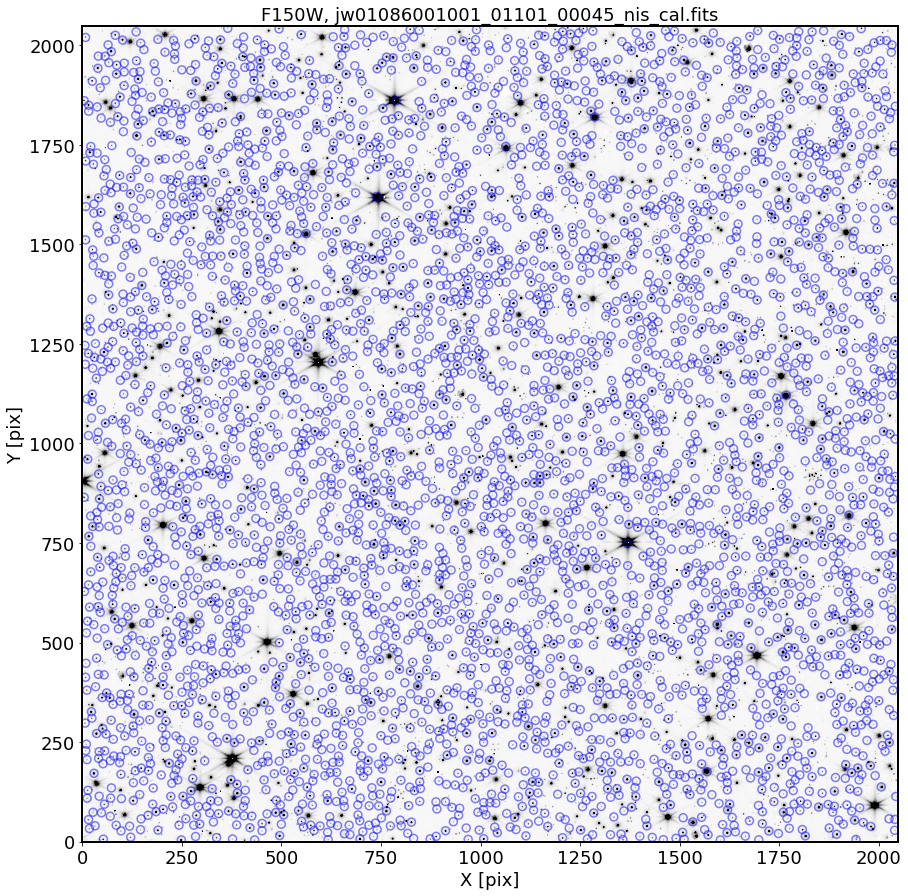

In [50]:
# From the plot above, you can find the FWHM and flux limits of good sources
# Apply these filters (or masks) and overplot the detected sources on the 
# image to make sure we're dealing with actual stars
for filt,filt_d in data_d.items():
    for fname,file_d in filt_d.items():
        
        sources = file_d["sources"]
        mask = (sources['fwhm'] > fwhm_lims[0]) & (sources['fwhm'] < fwhm_lims[1]) & (sources['flux'] > flux_lims[0]) 
        sources_masked = sources[mask]
        file_d["sources_masked"] = sources_masked
        positions = np.transpose((sources_masked['xcentroid'], sources_masked['ycentroid']))
        apertures = CircularAperture(positions, r=10)
        normlzd = simple_norm(file_d["data_cps"], 'sqrt', percent=99.)
        
        plt.imshow(file_d["data_cps"], norm=normlzd, cmap='Greys', origin='lower')
        apertures.plot(color='blue', lw=1.5, alpha=0.5)
        plt.xlabel("X [pix]")
        plt.ylabel("Y [pix]")
        plt.title(f"{filt.upper()}, {os.path.basename(fname)}")
        
        plt.show()
        if first_only is True:
            break

# Perform aperture photometry

In [12]:
# Define aperture and annulus sizes
aperture_sizes = [3, 5, 7, 10]
annulus_offset = (+3,+7)

# Now perform aperture photometry on the stars
for filt,filt_d in data_d.items():
    for fname,file_d in filt_d.items():
        sources_masked = file_d["sources_masked"]
        positions = np.transpose((sources_masked['xcentroid'], sources_masked['ycentroid']))
        for ap_size in aperture_sizes:
            apertures = CircularAperture(positions, r=ap_size)
            annulus_apertures = CircularAnnulus(positions, 
                                                r_in=ap_size+annulus_offset[0], 
                                                r_out=ap_size+annulus_offset[1])
            annulus_masks = annulus_apertures.to_mask(method='center')
            bkg_median = []
            for mask in annulus_masks:
                annulus_data = mask.multiply(file_d["data_cps"])
                annulus_data_1d = annulus_data[mask.data > 0]
                jnk0, median_sigclip, jnk1 = sigma_clipped_stats(annulus_data_1d)
                bkg_median.append(median_sigclip)
            bkg_median = np.array(bkg_median)
            phot = aperture_photometry(file_d["data_cps"], apertures)
            phot['annulus_median'] = bkg_median
            phot['aper_bkg'] = bkg_median * apertures.area
            phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
            file_d[f"phot_ap{ap_size}"] = phot

In [13]:
# From Kevin Volk's email sent to Tony on Mar 26, 2021
# Assumed A0V spectral template: Bohlin Sirius (2020)

niriss_info = """
#                        ADU/sec           Jy          Microns    (MJy/ster)/(ADU/s)      Jy/(ADU/s)
ins    filter         count_rate     mean_f_nu        pivot_wl      phot_mjsr          phot_jy
NIRISS F090W          2.804222e+11   8.371777e+03     0.902458      1.673899e-10       2.985419e-08
NIRISS F115W          2.347116e+11   6.508594e+03     1.149542      1.554807e-10       2.773018e-08
NIRISS F140M          7.340864e+10   4.757672e+03     1.404035      3.633885e-10       6.481080e-08
NIRISS F150W          1.391529e+11   4.346497e+03     1.493457      1.751341e-10       3.123539e-08
NIRISS F158M          6.487924e+10   3.939552e+03     1.582011      3.404590e-10       6.072129e-08
NIRISS F200W          9.570604e+10   2.755850e+03     1.992961      1.614508e-10       2.879494e-08
NIRISS F277W          5.573678e+10   1.575708e+03     2.764281      1.585104e-10       2.827052e-08
NIRISS F356W          3.667514e+10   9.791757e+02     3.593004      1.496969e-10       2.669862e-08
NIRISS F380M          6.607656e+09   8.561057e+02     3.825227      7.264468e-10       1.295627e-07
NIRISS F430M          4.290003e+09   6.923615e+02     4.283827      9.048971e-10       1.613895e-07
NIRISS F444W          2.242869e+10   6.615412e+02     4.427699      1.653776e-10       2.949531e-08
NIRISS F480M          3.839979e+09   5.582376e+02     4.815243      8.151061e-10       1.453752e-07
Guider 1              1.379334e+12   4.478894e+03     2.501078      1.684581e-11       3.247142e-09
Guider 2              1.604525e+12   4.291017e+03     2.591652      1.386584e-11       2.674322e-09
"""

t = ascii.read(niriss_info, data_start=1)
t

<Table length=14>
 ins   filter    count_rate   mean_f_nu pivot_wl  phot_mjsr     phot_jy   
 str6   str5      float64      float64  float64    float64      float64   
------ ------ --------------- --------- -------- ------------ ------------
NIRISS  F090W  280422200000.0  8371.777 0.902458 1.673899e-10 2.985419e-08
NIRISS  F115W  234711600000.0  6508.594 1.149542 1.554807e-10 2.773018e-08
NIRISS  F140M   73408640000.0  4757.672 1.404035 3.633885e-10  6.48108e-08
NIRISS  F150W  139152900000.0  4346.497 1.493457 1.751341e-10 3.123539e-08
NIRISS  F158M   64879240000.0  3939.552 1.582011  3.40459e-10 6.072129e-08
NIRISS  F200W   95706040000.0   2755.85 1.992961 1.614508e-10 2.879494e-08
NIRISS  F277W   55736780000.0  1575.708 2.764281 1.585104e-10 2.827052e-08
NIRISS  F356W   36675140000.0  979.1757 3.593004 1.496969e-10 2.669862e-08
NIRISS  F380M    6607656000.0  856.1057 3.825227 7.264468e-10 1.295627e-07
NIRISS  F430M    4290003000.0  692.3615 4.283827 9.048971e-10 1.613895e-07
NIRISS  F444W   22428690000.0  661.5412 4.427699 1.653776e-10 2.949531e-08
NIRISS  F480M    3839979000.0  558.2376 4.815243 8.151061e-10 1.453752e-07
Guider      1 1379334000000.0  4478.894 2.501078 1.684581e-11 3.247142e-09
Guider      2 1604525000000.0  4291.017 2.591652 1.386584e-11 2.674322e-09

<div class="alert alert-block alert-warning">
<u><b>USER INPUT</b></u>
    
You need to define the following variables:
* `ap_use`: The aperture size to use for all photometry going forward.
</div>

In [14]:
# Will this vary with filter?
ap_use = 3 # 5 7 10
phot_ap = f'phot_ap{ap_use}'

2021-05-21 16:59:03,793 - stpipe - WARNING - <ipython-input-15-63f3ef104cfe>:13: RuntimeWarning: invalid value encountered in log10
  file_d[phot_ap]['mag'] = -2.5 * np.log10(phot['aper_sum_bkgsub']) + zpt - 1.401 # where does 1.401 come from?

2021-05-21 16:59:03,794 - stpipe - WARNING - <ipython-input-15-63f3ef104cfe>:14: RuntimeWarning: invalid value encountered in sqrt
  file_d[phot_ap]['mag_err'] = 1.0857 * np.sqrt(phot['aper_sum_bkgsub']) / phot['aper_sum_bkgsub'] # where does 1.0857 come from?

2021-05-21 16:59:03,820 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/astropy/io/fits/card.py:264: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(



F150W


2021-05-21 16:59:04,816 - stpipe - WARNING - <ipython-input-15-63f3ef104cfe>:13: RuntimeWarning: invalid value encountered in log10
  file_d[phot_ap]['mag'] = -2.5 * np.log10(phot['aper_sum_bkgsub']) + zpt - 1.401 # where does 1.401 come from?

2021-05-21 16:59:04,817 - stpipe - WARNING - <ipython-input-15-63f3ef104cfe>:14: RuntimeWarning: invalid value encountered in sqrt
  file_d[phot_ap]['mag_err'] = 1.0857 * np.sqrt(phot['aper_sum_bkgsub']) / phot['aper_sum_bkgsub'] # where does 1.0857 come from?

2021-05-21 16:59:04,841 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/astropy/io/fits/card.py:264: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(



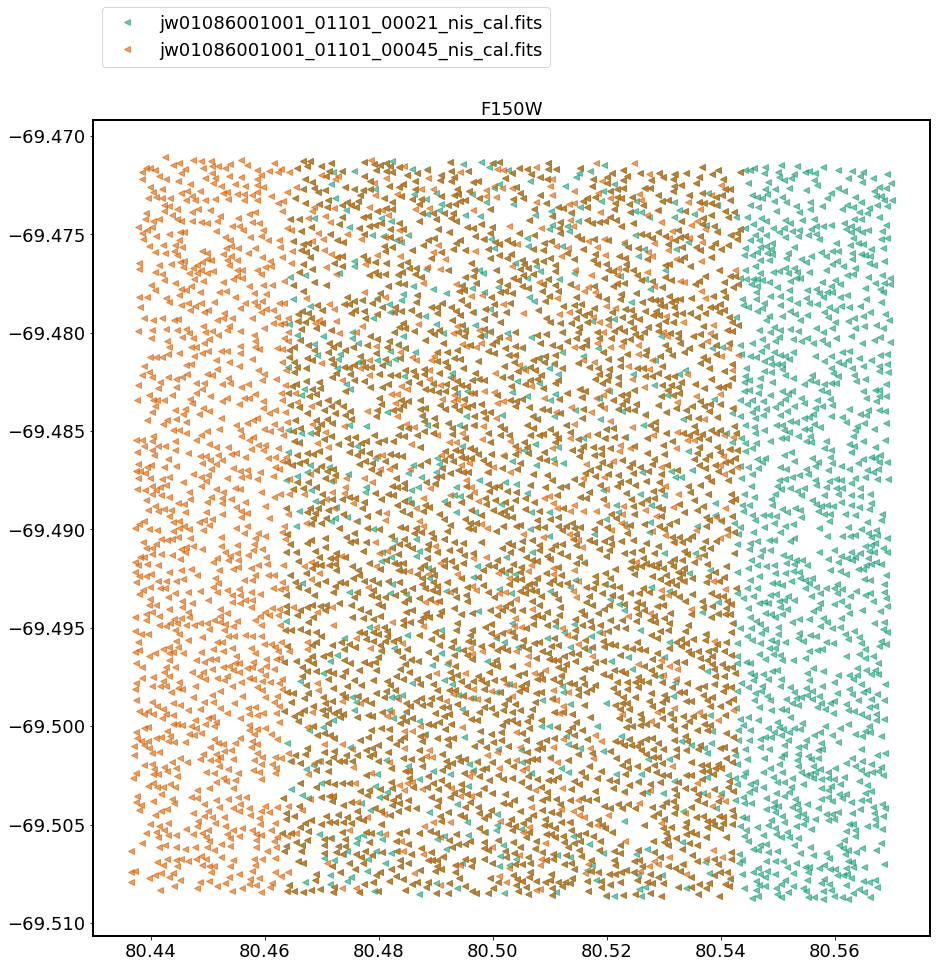

In [15]:
# For now just use aperture radius=3 photometry
# Colorblind-safe palettes below, either set works
#colors = ["#fb9a99", "#33a02c", "#b2df8a", "#1f78b4", "#a6cee3"]
if len(data_d) <= 5: 
    colors = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e"]
else:
    colors = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "a6cee3", "1f78b4", "b2df8a", "33a02c", "fb9a99", "e31a1c", "fdbf6f", "ff7f00", "cab2d6", "6a3d9a", "ffff99", "b15928"]
for filt,filt_d in data_d.items():
    filtkey = filt.split("/")[0]
    print(filtkey)
    # Magnitude zero points defined using the table above.
    count_rate = t[t['filter'] == filtkey.upper()]['count_rate'][0]
    zpt = 2.5 * np.log10(count_rate)
    for i,(fname,file_d) in enumerate(filt_d.items()):
        phot = file_d[phot_ap]
        file_d[phot_ap]['mag'] = -2.5 * np.log10(phot['aper_sum_bkgsub']) + zpt - 1.401 # where does 1.401 come from?
        file_d[phot_ap]['mag_err'] = 1.0857 * np.sqrt(phot['aper_sum_bkgsub']) / phot['aper_sum_bkgsub'] # where does 1.0857 come from?
        
        # Convert the detected positions into sky coordinates (RA, Dec) in degrees
        detector_to_world = file_d["cal_datamodel"].meta.wcs.get_transform('detector', 'world')
        ra, dec = detector_to_world(phot["xcenter"].value, phot["ycenter"]  .value)
        file_d[phot_ap]["ra_deg"] = ra
        file_d[phot_ap]["dec_deg"] = dec
        coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        file_d[phot_ap]['coords'] = coords
        
        # At this stage, let's save the resulting photometry table to files so we don't have to 
        # repeat all the steps above in case something goes wrong with this session
        photfile0 = os.path.basename(fname).replace(".fits", "_photutils_ap3.fits")
        photfile = os.path.join(outdir, photfile0)
        file_d[phot_ap].write(photfile, format="fits", overwrite=True)
       
        # Let's take a look at how the sky coordinates look like for each catalog
        plt.plot(ra, dec, '<', color=colors[i], alpha=0.6, 
                 label=os.path.basename(fname))
        plt.title(filt.upper())
        plt.legend(bbox_to_anchor=(0, 1.15), loc="upper left")
    plt.show()

# Match stars in each image pair

F150W
Ref:        /ifs/jwst/wit/niriss/tsohn/mirage_simulations/NIS-011/jw01086001001_01101_00021_nis_cal.fits
Comparison: /ifs/jwst/wit/niriss/tsohn/mirage_simulations/NIS-011/jw01086001001_01101_00045_nis_cal.fits


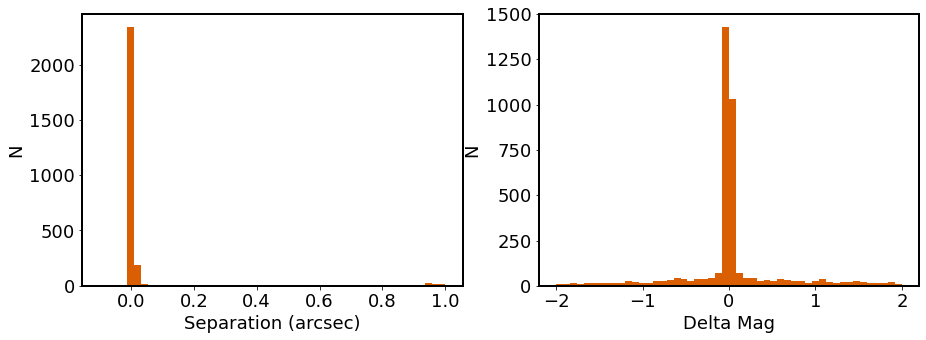

In [80]:
# Now let's do the coordinate-based crossmatching
# For this, we use the simple match_coordinates_sky method from astropy.coordinates

for filt,filt_d in data_d.items():
    ref_im = ref_ims[filt]
    phot0 = filt_d[ref_im][phot_ap]
    filt_d[ref_im]['source_catalog'] = np.nan

    for fname,file_d in filt_d.items():
        if fname == ref_im:
            continue
        # Note: idx is the index of c1
        print(filt)
        print(f"Ref:        {ref_im}")
        print(f"Comparison: {fname}")
        photi = file_d[phot_ap]
        idx, d2d, d3d = match_coordinates_sky(photi['coords'], phot0['coords'])
        
        d0 = {'ra_deg_ref': phot0['ra_deg'][idx], 'dec_deg_ref': phot0['dec_deg'][idx], 
              'x_ref': phot0['xcenter'][idx], 'y_ref': phot0['ycenter'][idx],
              'mag_ref': phot0['mag'][idx], 'magerr_ref': phot0['mag_err'][idx]}
        t0 = Table(d0)

        # Inspect the distance between matched sources to find out how to select good sources.
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].hist(d2d.arcsecond, histtype='bar', facecolor=colors[i], linewidth=1.2, bins=50, range=(-0.1,1))
        axes[0].set_xlabel("Separation (arcsec)")
        axes[0].set_ylabel("N")
        
        # Also inspect difference in magnitudes.
        dmag = photi['mag'] - phot0['mag'][idx]
        axes[1].hist(dmag, histtype='bar', facecolor=colors[i], linewidth=1.2, bins=50, range=(-2,2))
        axes[1].set_xlabel("Delta Mag")
        axes[1].set_ylabel("N")

        plt.show()
                
        di = {'ra_deg': photi['ra_deg'], 'dec_deg': photi['dec_deg'], 
              'x': photi['xcenter'], 'y': photi['ycenter'],
              'mag': photi['mag'], 'magerr': photi['mag_err'],
              'sep2d_arcsec': d2d.arcsecond}
        ti = Table(di)
        ti0 = hstack([t0, ti])
        file_d['source_catalog'] = ti0
        

Ref:        /ifs/jwst/wit/niriss/tsohn/mirage_simulations/NIS-011/jw01086001001_01101_00021_nis_cal.fits
Comparison: /ifs/jwst/wit/niriss/tsohn/mirage_simulations/NIS-011/jw01086001001_01101_00045_nis_cal.fits


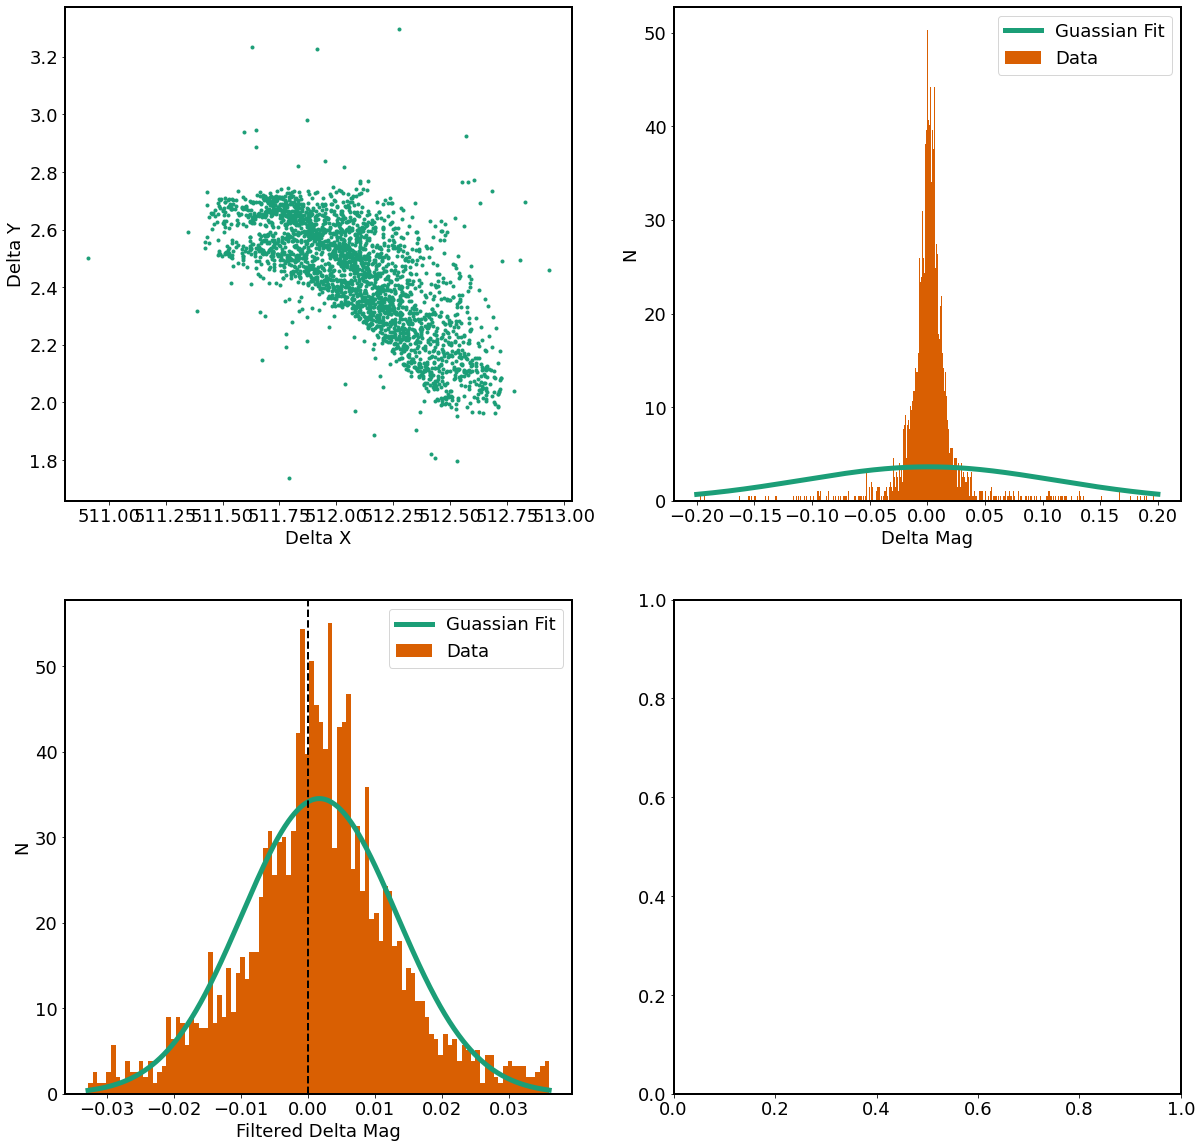

In [73]:
# Now filter out the bad matches and write the crossmatched catalog to a FITS table
for filt,filt_d in data_d.items():
    ref_im = ref_ims[filt]
    for i,(fname,file_d) in enumerate(filt_d.items()):
        if fname == ref_im:
            file_d['filtered_dmag'] = np.nan
            file_d['filtered_xref'] = np.nan
            file_d['filtered_yref'] = np.nan
            continue
        print(filt)
        print(f"Ref:        {ref_im}")
        print(f"Comparison: {fname}")
        fig, axes0 = plt.subplots(2, 2, figsize=(20,20))
        axes = axes0.flatten()

        ti0 = file_d['source_catalog']
        mask = (ti0['sep2d_arcsec'] < 0.1)
        t_filtered = ti0[mask]
        # To-do: write >1 fits file
        t_filtered.write(os.path.join(outdir, 'crossmatched.fits'), format='fits', overwrite=True)
        
        # Plot delta y vs delta x
        delx = t_filtered['x_ref'] - t_filtered['x']
        dely = t_filtered['y_ref'] - t_filtered['y']
        axes[0].plot(delx, dely, 'o', color=colors[0], markersize=3.0)
        axes[0].set_xlabel("Delta X")
        axes[0].set_ylabel("Delta Y")
        
        dmag0 = t_filtered['mag_ref'] - t_filtered['mag']
        dmag = dmag0.data
        dmag = np.nan_to_num(dmag, nan=0)
        axes[1].hist(dmag, color=colors[i], density=True, linewidth=1.2, bins=500, range=[-0.2,0.2], label="Data")
        mu, std = norm.fit(dmag)
        x = np.linspace(-.2, .2, 500)
        p = norm.pdf(x, mu, std)
        axes[1].plot(x, p, colors[0], linewidth=5, label="Guassian Fit")
        axes[1].legend(loc="best")
        axes[1].set_xlabel("Delta Mag")
        axes[1].set_ylabel("N")
        
        sigma_mask = sigma_clip(dmag, sigma=3, maxiters=10, masked=True)
        filtered_dmag = dmag[~sigma_mask.mask]
        file_d['filtered_dmag'] = filtered_dmag
        file_d['filtered_xref'] = t_filtered['x_ref'][~sigma_mask.mask]
        file_d['filtered_yref'] = t_filtered['y_ref'][~sigma_mask.mask]
        axes[2].hist(filtered_dmag, bins=100, density=True, color=colors[i], label="Data")
        mu, std = norm.fit(filtered_dmag)
        xmin = np.min(filtered_dmag)
        xmax = np.max(filtered_dmag)
        x = np.linspace(xmin, xmax, 500)
        p = norm.pdf(x, mu, std)
        axes[2].plot(x, p, colors[0], linewidth=5, label="Guassian Fit")
        axes[2].axvline(0, linestyle="--", color="k")
        axes[2].legend(loc="best")
        axes[2].set_xlabel("Sigma-clipped Delta Mag")
        axes[2].set_ylabel("N")

        plt.show()

# Combine all delta mag measurements as a function of ref. image X & Y

In [89]:
# Create master x_ref, y_ref, and dmag arrays
# From here on, we do not loop over any files, just filters
xref = np.array([])
yref = np.array([])
res = np.array([])
final_data = {}
for filt,filt_d in data_d.items():
    final_data[filt] = {}
    ref_im = ref_ims[filt]
    for fname,file_d in filt_d.items():
        if fname == ref_im:
            continue
        x_ref = np.concatenate((xref, file_d['filtered_xref']))
        y_ref = np.concatenate((yref, file_d['filtered_yref']))
        res = np.concatenate((res, file_d['filtered_dmag']))
        final_data[filt]['x_ref'] = x_ref
        final_data[filt]['y_ref'] = y_ref
        final_data[filt]['res'] = res

2021-05-21 18:08:01,419 - stpipe - WARNING - <ipython-input-106-1a1651d379c1>:8: RuntimeWarning: invalid value encountered in true_divide
  zi /= counts



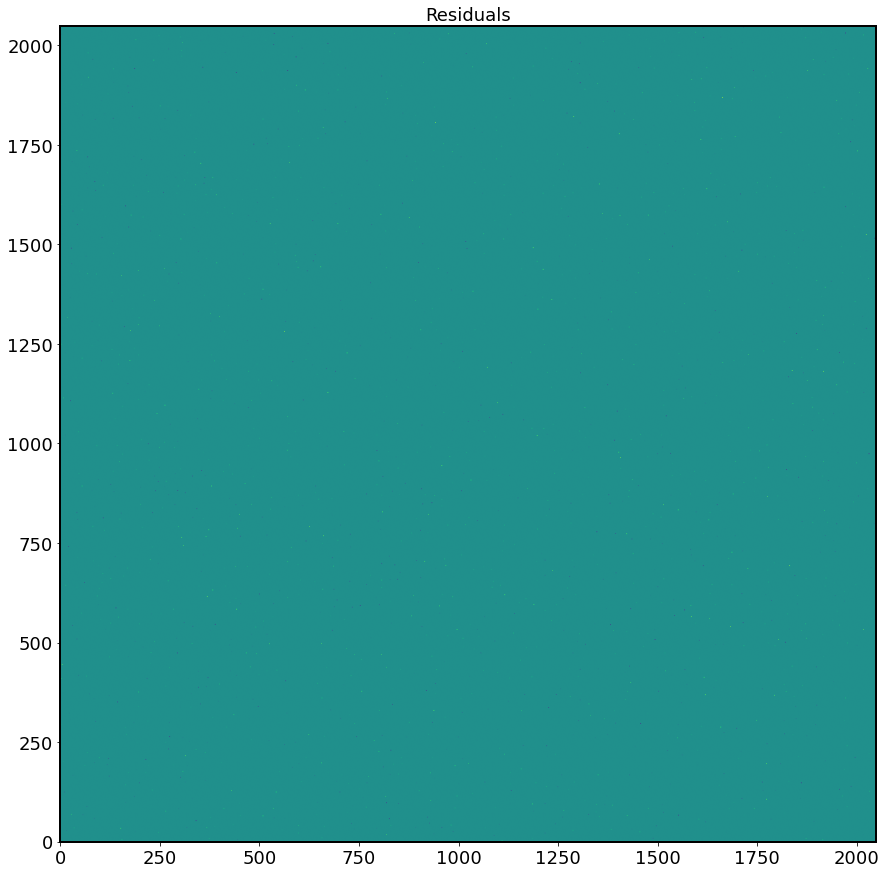

In [106]:
# Make 2D plot of delta mag for diagnostic purposes only
# Bin x and y data into an image
# From: https://stackoverflow.com/questions/30764955/python-numpy-create-2d-array-of-values-based-on-coordinates
for filt,filt_d in final_data.items():
    zi, yi, xi = np.histogram2d(filt_d['y_ref'], filt_d['x_ref'], bins=(2048,2048), 
                                weights=filt_d['res'], normed=False)
    counts, _, _ = np.histogram2d(filt_d['y_ref'], filt_d['x_ref'], bins=(2048,2048))
    zi /= counts
    dmag_im = np.nan_to_num(zi, nan=0)
    plt.imshow(dmag_im, origin="lower", vmin=-.01, vmax=.01)
    plt.title("Residuals")

# Fit variety of models to magnitude residuals (delta mag)

In [22]:
# Define a model function for a 2D Gaussian that can be fit
# From: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
def twod_gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x = xy[0]
    y = xy[1]
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

In [93]:
# Now fit 2D polynomial, legendre, and chebyshev functions of the orders specified below. Also fit a 2D gaussian.
orders = [1, 2, 3, 4, 5]
for filt,filt_d in final_data.items():
    actualx = filt_d['x_ref']
    actualy = filt_d['y_ref']
    actualz = filt_d['res']
    fts = {}
    for i in orders:
        poly = models.Polynomial2D(degree=i)
        leg = models.Legendre2D(x_degree=i, y_degree=i)
        cheby = models.Chebyshev2D(x_degree=i, y_degree=i)  
        fitter = LevMarLSQFitter()
        poly_fit = fitter(poly, actualx, actualy, actualz)
        leg_fit = fitter(leg, actualx, actualy, actualz)
        cheby_fit = fitter(cheby, actualx, actualy, actualz)
        fts[f'polynomial order={i}'] = poly_fit
        fts[f'legendre order={i}'] = leg_fit
        fts[f'chebyshev order={i}'] = cheby_fit
    popt, pcov = opt.curve_fit(twod_gaussian, (actualx, actualy), actualz)
    fts['2d gaussian'] = popt
    filt_d['fts'] = fts

2021-05-21 18:03:31,629 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/astropy/modeling/fitting.py:1708: AstropyUserWarning: Model is linear in parameters; consider using linear fitting methods.
  warnings.warn('Model is linear in parameters; '

2021-05-21 18:03:32,197 - stpipe - WARNING - /Users/jotaylor/miniconda3/envs/jwstdev/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



In [98]:
# Now evaluate each fit and estimate its goodness
x = y = np.arange(2048)
for filt,filt_d in final_data.items():
    print(filt)
    fts = filt_d['fts']
    for fitname,fit in fts.items():
        if fitname == "2d gaussian":
            fit_z = twod_gaussian((actualx, actualy), *fit)
        else:
            fit_z = fit(actualx, actualy)
        rmse = mean_squared_error(actualz, fit_z, squared=False)
        chi2 = np.sum( (actualz-fit_z)**2 / fit_z )
        print(fitname)
        print(f'\tRMSE:{rmse:.5f}, Chi2: {chi2:.4f}')
    

F150W
polynomial order=1
	RMSE:0.01153, Chi2: 234.8797
legendre order=1
	RMSE:0.01151, Chi2: 321.2358
chebyshev order=1
	RMSE:0.01151, Chi2: 321.2358
polynomial order=2
	RMSE:0.01150, Chi2: 187.7509
legendre order=2
	RMSE:0.01149, Chi2: -1309.1338
chebyshev order=2
	RMSE:0.01149, Chi2: -1309.1338
polynomial order=3
	RMSE:0.01149, Chi2: 207.3584
legendre order=3
	RMSE:0.01148, Chi2: -5.2183
chebyshev order=3
	RMSE:0.01148, Chi2: -5.2183
polynomial order=4
	RMSE:0.01148, Chi2: 188.6010
legendre order=4
	RMSE:0.01144, Chi2: 104.9274
chebyshev order=4
	RMSE:0.01144, Chi2: 104.9274
polynomial order=5
	RMSE:0.01146, Chi2: 200.5679
legendre order=5
	RMSE:0.01142, Chi2: 905.5429
chebyshev order=5
	RMSE:0.01142, Chi2: 905.5420
2d gaussian
	RMSE:0.01155, Chi2: 174.5707


<div class="alert alert-block alert-warning">
<u><b>USER INPUT</b></u>
    
You need to define the following variables:
* `final_fitname`: The name of the fit to adopt for the delta flat. This assumes the same fit for all filters.
</div>

In [99]:
final_fitname = 'polynomial order=3'

F150W


<IPython.core.display.Javascript object>


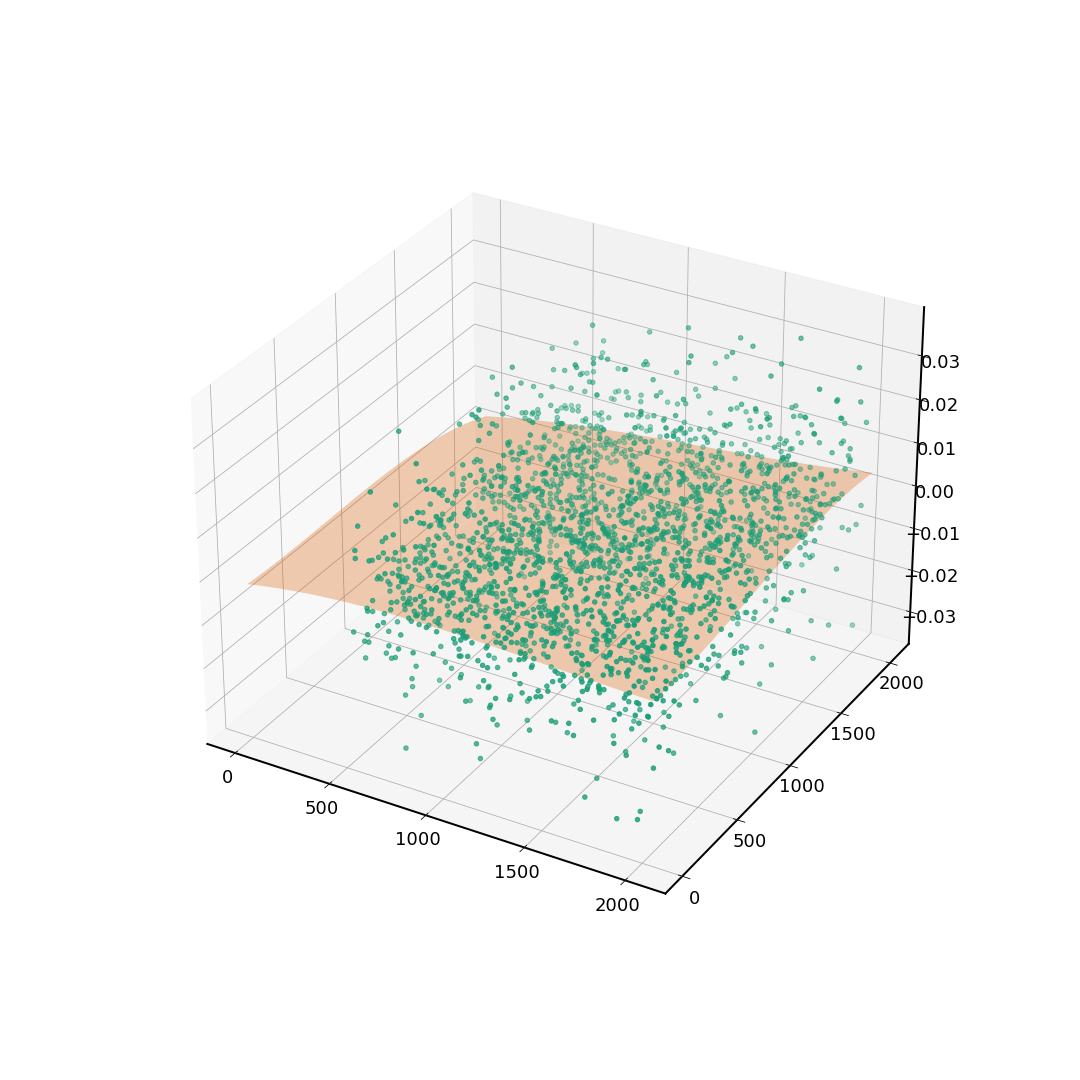

In [112]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

xmesh, ymesh = np.meshgrid(x, y)
for filt,filt_d in final_data.items():
    print(filt)
    fts = filt_d['fts']
    final_fit = fts[final_fitname]
    # Evaluate the fit on an integer grid for plotting below    
    if final_fitname == "2d gaussian":    
        zmesh = twod_gaussian((xmesh, ymesh), *final_fit)
    else:
        zmesh = final_fit(xmesh, ymesh)
    filt_d['fit_zmesh'] = zmesh
    fig = plt.figure(figsize=(15,15)) 
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(actualx, actualy, actualz, marker='o', s=20, c=colors[0])
    downsample = 10
    ax.plot_surface(xmesh, ymesh, zmesh, rcount=downsample, ccount=downsample, color=colors[1], shade=False, alpha=0.3)

In [113]:
# You have to do this to undo the 3D plotting capabilities
%matplotlib inline
from matplotlib import style, pyplot as plt
params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,
        'axes.linewidth':2,'animation.html': 'html5',
        'figure.figsize':(15,15)}
plt.rcParams.update(params)

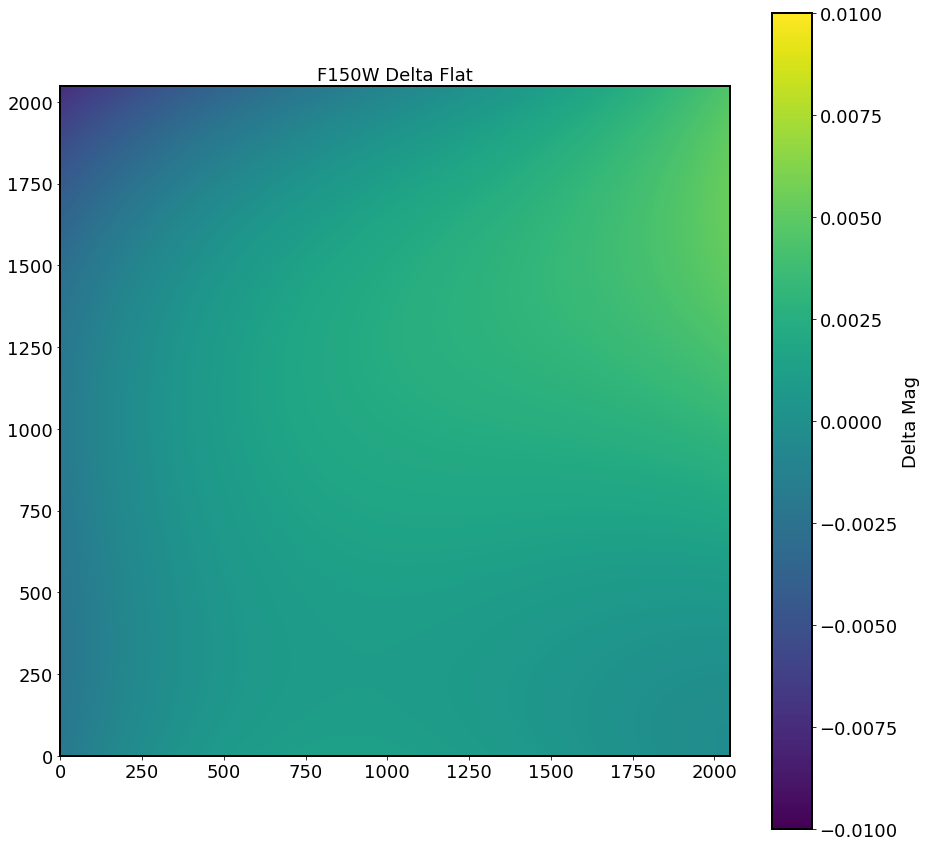

In [118]:
# Now plot the fit in 2D
for filt,filt_d in final_data.items():
    im = pl.imshow(filt_d['fit_zmesh'], origin='lower', vmin=-.01, vmax=.01)
    plt.colorbar(im, label="Delta Mag")
    plt.title(f'{filt} Delta Flat')

# Create delta flat file for each filter

In [125]:
# Now package the data into a fits file. 
# Compute the mean in the central 100x100 pixels and use that to normalize the image.
for filt,filt_d in final_data.items():
    im = filt_d['fit_zmesh']
    central = im[974:1075, 974:1075]
    avg = np.average(central)
    nrmlzd = im/avg
    outname0 = f'{filt}_deltaflat.fits'
    outname = os.path.join(outdir, outname0)
    
    hdr0 = fits.Header()
    hdr0['FILTER'] = filt
    hdu0 = fits.PrimaryHDU(header=hdr0)
    hdu1 = fits.ImageHDU(nrmlzd)
    hdulist = fits.HDUList([hdu0, hdu1])
    
    hdulist.writeto(outname, overwrite=True)
    print(f'Wrote file: {outname}')

Wrote file: /System/Volumes/Data/user/jotaylor/git/jo_niriss_illumflat_notebook/niriss_illumflat_notebook/out/F150W_deltaflat.fits
